In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import keras
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

colnames = ['surgery', 'age', 'hospital number', 'rectal temperature', 'pulse', 'respiratory rate', 'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', 'pain', 'peristalsis', 'abdominal distension', 'nasogastric tube',
            'nasogastric reflux', 'nasogastric reflux PH', 'rectal examination', 'abdomen', 'packed cell volume', 'total protein', 'abdominocentesis appearance', 'abdomcentesis total protein', 'outcome', 'surgical lesion', 'lesion type', 'lesion type2', 'lesion type3', 'pathology data']
dropped_colnames = ['nasogastric reflux PH', 'abdominocentesis appearance', 'abdomcentesis total protein', 'hospital number',
                    'abdomen', 'nasogastric tube', 'nasogastric reflux', 'rectal examination', 'lesion type2', 'lesion type3']
train_colnames = set(colnames).difference(dropped_colnames)
train_colnames = [x for x in train_colnames if x != "outcome"]
cat_colnames = ['surgery', 'age', 'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', 'pain', 'peristalsis', 'abdominal distension',
                'surgical lesion', 'pathology data']
numerical_colnames = ['rectal temperature', 'pulse', 'respiratory rate',
                      'packed cell volume', 'total protein']

# Read dataset file
def read_data(dataset_name):
    loc = "data\%s" % (dataset_name)
    df = pd.read_csv(loc, sep=" ", names=colnames, header=None)
    df.columns.names = ["id"]
    df.drop(dropped_colnames, axis=1, inplace=True)
    df = df.replace("?", np.nan)
    df = df.dropna(subset=["outcome"])
    # split into data and target
    X, y = df.loc[:, df.columns != "outcome"], df.loc[:, "outcome"]
    return X, y


X, y = read_data("horse-colic.data")

# Cast Object types to float
for col in train_colnames:
    X = X.astype({col: float})

In [2]:
# convert to numpy arrays
X_numpy = np.array(X)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to one hot encoded variables
hot_y = np_utils.to_categorical(encoded_y)

In [3]:
# Pre-processing
filled_df = X.copy()
# Replacing missing values of categorical attributes with the most frequant value
cat_fill = filled_df.loc[:, cat_colnames]
for col in cat_colnames:
    filled_df[cat_colnames] = cat_fill.fillna(filled_df[col].mode()[0])

# Replacing missing values of numerical attributes with the mean value
filled_df[numerical_colnames] = filled_df[numerical_colnames].fillna(
    filled_df[numerical_colnames].mean()
)

for feature in train_colnames:
  le = LabelEncoder()
  filled_df[feature] = le.fit_transform(filled_df[feature])

# Normalization
normalized_df = filled_df.copy()
to_norm = normalized_df.loc[:, numerical_colnames]
normalized_df[numerical_colnames] = preprocessing.normalize(to_norm)

X = normalized_df


Dataset shape is (299, 17)
_________________________________________________

Dataset info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery                     299 non-null    int64  
 1   age                         299 non-null    int64  
 2   rectal temperature          299 non-null    float64
 3   pulse                       299 non-null    float64
 4   respiratory rate            299 non-null    float64
 5   temperature of extremities  299 non-null    int64  
 6   peripheral pulse            299 non-null    int64  
 7   mucous membranes            299 non-null    int64  
 8   capillary refill time       299 non-null    int64  
 9   pain                        299 non-null    int64  
 10  peristalsis                 299 non-null    int64  
 11  abdominal distension        299 non-null    int64  
 12 

C:\Users\savag\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='outcome', ylabel='count'>

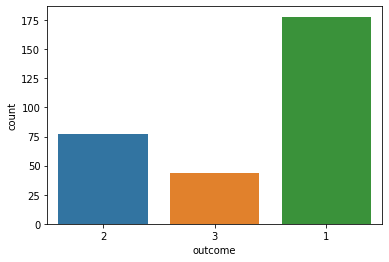

In [4]:
print('Dataset shape is', X.shape)
print('_________________________________________________\n')
print('Dataset info:\n')
X.info()
print('\n_________________________________________________\n')
print('Number of null values for each feature:\n\n', X.isnull().sum())
print('\n_________________________________________________\n')
print(X.head())
sns.countplot(y)

In [5]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, shuffle=True)

In [6]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train.ravel())
b_leafSize = best_model.best_estimator_.get_params()['leaf_size']
b_p = best_model.best_estimator_.get_params()['p']
b_nNeighbors = best_model.best_estimator_.get_params()['n_neighbors']
#Print The value of best Hyperparameters
print('Best leaf_size:', b_leafSize)
print('Best p:', b_p)
print('Best n_neighbors:', b_nNeighbors)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 2


1 0.6333333333333333
2 0.5833333333333334
3 0.55
4 0.5833333333333334
5 0.6
6 0.65
7 0.6333333333333333
8 0.65
9 0.65


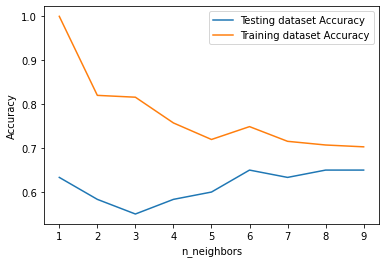

In [7]:
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, leaf_size=b_leafSize, p=b_p)
    knn.fit(X_train, y_train)
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    print(k, knn.score(X_test, y_test))
 
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

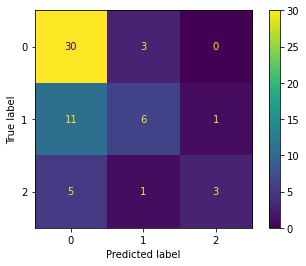

              precision    recall  f1-score   support

           0       0.65      0.91      0.76        33
           1       0.60      0.33      0.43        18
           2       0.75      0.33      0.46         9

    accuracy                           0.65        60
   macro avg       0.67      0.53      0.55        60
weighted avg       0.65      0.65      0.62        60



In [12]:
# From results of Hyperparameters tuning "GridSearchCV" algorithm for knn alogrith to our dataset, testing and ploting the data
# with diffrent n_neighbors. n_neighbors: 8 and 9 proved to be the best
knn = KNeighborsClassifier(n_neighbors=k, leaf_size=b_leafSize, p=b_p)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test, preds))